# Problem Statement:

Defining an "adopted user" as a user who has logged  into  the  product  on  three  separate
days in at least one seven-day period, **identify  which  factors  predict  future  user
adoption**.

We  suggest  spending  1-2  hours  on  this,  but  you're  welcome  to  spend  more  or  less.
Please  send  us  a  brief  writeup  of  your  findings  (the  more  concise,  the  better  --  no  more
than  one  page),  along  with  any  summary  tables,  graphs,  code,  or  queries  that  can  help
us  understand  your  approach.  Please  note  any  factors  you  considered  or  investigation
you  did,  even  if  they  did  not  pan  out.  Feel  free  to  identify  any  further  research  or  data
you  think  would  be  valuable.

The  data  is  available  as  two  attached  CSV  files:
1. takehome_user_engagement.csv
2. takehome_users.csv

The  data  has  the  following  two  tables:

1. A  user  table  ( "takehome_users" )  with  data  on  12,000  users  who  signed  up  for  the product  in  the  last  two  years.   This  table  includes:
    1. name:  the  user's  name
    2. object_id:   the  user's  id
    3. email:  email  address
    4. creation_source:   how  their  account  was  created.  This  takes  on  one of  5  values:
        1. PERSONAL_PROJECTS:  invited  to  join  another  user's personal  workspace
        2. GUEST_INVITE:  invited  to  an  organization  as  a  guest (limited  permissions)
        3. ORG_INVITE:  invited  to  an  organization  (as  a  full  member)
        4. SIGNUP:  signed  up  via  the  website
        5. SIGNUP_GOOGLE_AUTH:  signed  up  using  Google Authentication  (using  a  Google  email  account  for  their  login id)
    2. creation_time:  when  they  created  their  account
    3. last_session_creation_time:   unix  timestamp  of  last  login
    4. opted_in_to_mailing_list:  whether  they  have  opted  into  receiving marketing  emails
    5. enabled_for_marketing_drip:  whether  they  are  on  the  regular marketing  email  drip
    6. org_id:   the  organization  (group  of  users)  they  belong  to
    7. invited_by_user_id:   which  user  invited  them  to  join  (if  applicable).

2. A  usage  summary  table  ( "takehome_user_engagement" )  that  has  a  row  for  each  day that  a  user  logged  into  the  product.

# Strategy:

1. Load data
2. Determine which users are "adopted users"
3. Determine feature importances through Random Forests

### Imports

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import time

### Load Data

In [2]:
user_eng_raw = pd.read_csv('takehome_user_engagement.csv')
users_raw = pd.read_csv('takehome_users.csv')

In [3]:
user_eng = user_eng_raw.copy()
user_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
users = users_raw.copy()
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


### Determine the "Adopted Users"

In [5]:
# order the entries
user_eng.set_index(['user_id'], inplace=True)
user_eng.sort_index(inplace=True)
user_eng.head()

,time_stamp,visited
user_id,,
1,2014-04-22 03:53:30,1
2,2013-11-15 03:45:04,1
2,2013-11-29 03:45:04,1
2,2013-12-09 03:45:04,1
2,2013-12-25 03:45:04,1


In [6]:
# convert time_stamps into datetimes
user_eng['time_stamp'] = user_eng['time_stamp'].apply(lambda time: dt.datetime.strptime(time, '%Y-%m-%d %H:%M:%S'))

In [7]:
# initialize users as not adopted
users['adopted'] = False
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,False
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False


In [8]:
# unique user_id
user_ids = user_eng.index.unique()

# for each user
for i in user_ids:
    
    # initialize/reset adopted status
    adopted = False
    
    # copy user visits
    user_visits = user_eng[user_eng.index==i]
    
    # if more than 1 visit, else adopted=False
    if len(user_visits) > 1: 
        
        # increment left index 1 at a time
        for j in range(len(user_visits)):
            
            # increment right index 1 at a time
            for k in range(j, len(user_visits)):

                # if window's time delta is greater than 7 days, break loop to slide window start
                timedelta = (user_visits.iloc[k]['time_stamp'] - user_visits.iloc[j]['time_stamp'])
                if timedelta > dt.timedelta(days=7):
                    break

                # sum unique days
                date_stamps = user_visits.iloc[j:k]['time_stamp'].apply(lambda date: date.strftime('%Y-%m-%d'))
                if len(date_stamps.unique()) >= 3:
                    adopted = True
                    break
        
            # user considered "adopted"
            if adopted:
                # update user adopted status
                users.loc[users['object_id']==i, 'adopted'] = True
                # move on to the next user
                break

In [9]:
# check class balance
users['adopted'].value_counts()

adopted
False    10661
True      1339
Name: count, dtype: int64

### Extract Features

In [10]:
# drop NaN rows
users.dropna(axis=0, inplace=True)

#### Time features

In [11]:
# convert creation_time string to datetime
users['creation_time'] = users['creation_time'].apply(lambda time: dt.datetime.strptime(time, '%Y-%m-%d %H:%M:%S'))

# get year, month, day, hour features
users['creation_year']  = users['creation_time'].apply(lambda time: time.year)
users['creation_month'] = users['creation_time'].apply(lambda time: time.month)
users['creation_day']   = users['creation_time'].apply(lambda time: time.day)
users['creation_hour']  = users['creation_time'].apply(lambda time: time.hour)

# convert last_session_creation_time from UNIX to datetime
users['last_session_creation_time'] = users['last_session_creation_time'].apply(lambda date_time: dt.datetime.fromtimestamp(date_time))

users['last_session_year']  = users['last_session_creation_time'].apply(lambda time: time.year)
users['last_session_month'] = users['last_session_creation_time'].apply(lambda time: time.month)
users['last_session_day']   = users['last_session_creation_time'].apply(lambda time: time.day)
users['last_session_hour']  = users['last_session_creation_time'].apply(lambda time: time.hour)

# convert creation_time datetime into UNIX timestamps
users['creation_time'] = users['creation_time'].apply(lambda date_time: time.mktime(date_time.timetuple()))
users['last_session_creation_time'] = users['last_session_creation_time'].apply(lambda date_time: time.mktime(date_time.timetuple()))
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_year,creation_month,creation_day,creation_hour,last_session_year,last_session_month,last_session_day,last_session_hour
0,1,1.398157e+09,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False,2014,4,22,3,2014,4,21,22
1,2,1.384509e+09,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,False,2013,11,15,3,2014,3,30,22
2,3,1.363753e+09,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False,2013,3,19,23,2013,3,19,18
3,4,1.369142e+09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False,2013,5,21,8,2013,5,22,3
4,5,1.358439e+09,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False,2013,1,17,10,2013,1,22,4


#### Email features

In [12]:
# create email domain feature
import re
users['email_domain'] = users['email'].apply(lambda email: re.search("@[\w.]+", email).group())

In [13]:
# drop columns with private information that is unique to the user
users.drop(['name', 'email', 'invited_by_user_id'], axis=1, inplace=True)
users.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,creation_year,creation_month,creation_day,creation_hour,last_session_year,last_session_month,last_session_day,last_session_hour,email_domain
0,1,1.398157e+09,GUEST_INVITE,1.398139e+09,1,0,11,False,2014,4,22,3,2014,4,21,22,@yahoo.com
1,2,1.384509e+09,ORG_INVITE,1.396238e+09,0,0,1,False,2013,11,15,3,2014,3,30,22,@gustr.com
2,3,1.363753e+09,ORG_INVITE,1.363735e+09,0,0,94,False,2013,3,19,23,2013,3,19,18,@gustr.com
3,4,1.369142e+09,GUEST_INVITE,1.369210e+09,0,0,1,False,2013,5,21,8,2013,5,22,3,@yahoo.com
4,5,1.358439e+09,GUEST_INVITE,1.358850e+09,0,0,193,False,2013,1,17,10,2013,1,22,4,@yahoo.com


### Find which features correlate the most with the adopted users

In [14]:
# check types
users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4776 entries, 0 to 11997
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   4776 non-null   int64  
 1   creation_time               4776 non-null   float64
 2   creation_source             4776 non-null   object 
 3   last_session_creation_time  4776 non-null   float64
 4   opted_in_to_mailing_list    4776 non-null   int64  
 5   enabled_for_marketing_drip  4776 non-null   int64  
 6   org_id                      4776 non-null   int64  
 7   adopted                     4776 non-null   bool   
 8   creation_year               4776 non-null   int64  
 9   creation_month              4776 non-null   int64  
 10  creation_day                4776 non-null   int64  
 11  creation_hour               4776 non-null   int64  
 12  last_session_year           4776 non-null   int64  
 13  last_session_month          4776 non-

In [15]:
users = pd.get_dummies(users, columns=['creation_source', 'email_domain'])

In [16]:
users.set_index('object_id', inplace=True)

In [17]:
# create X and y datasets
X = users.drop('adopted', axis=1)
y = users[['adopted']]

In [18]:
# check class balance
y.value_counts()

adopted
False      4011
True        765
Name: count, dtype: int64

In [19]:
# split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [20]:
# check split class balance
y_train.value_counts()

adopted
False      3007
True        575
Name: count, dtype: int64

### Use random forest to determine feature importances

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
rf = RandomForestClassifier()
rf.fit(X_train, np.ravel(y_train))

RandomForestClassifier()

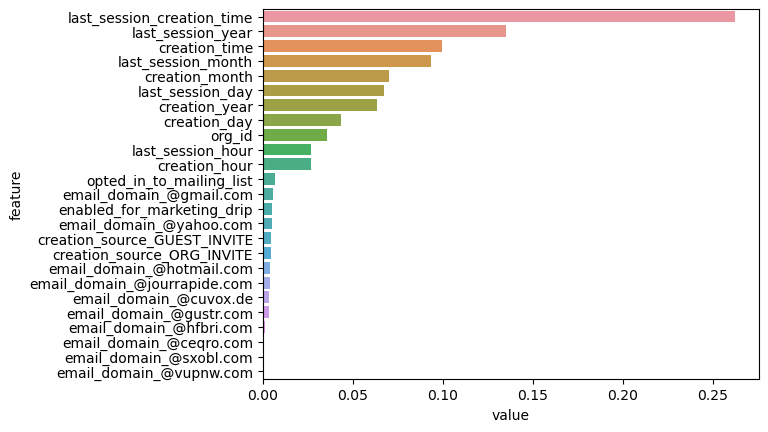

In [23]:
feature_importances = pd.DataFrame({'feature':rf.feature_names_in_, 'value':rf.feature_importances_})
feature_importances.sort_values('value', ascending=False, ignore_index=True, inplace=True)
sns.barplot(data=feature_importances[:25], y='feature', x='value')
plt.show()

In [24]:
# get predictions
y_pred_rf = rf.predict(X_test)

In [25]:
print('accuracy:  ' + str(accuracy_score(y_test, y_pred_rf)) + ' ' + str(str(accuracy_score(y_test, y_pred_rf, normalize=False))) + '/' + str(str(len(y_test))))
print('precision: ' + str(precision_score(y_test, y_pred_rf)))
print('recall:    ' + str(recall_score(y_test, y_pred_rf)))

accuracy:  0.9472361809045227 1131/1194
precision: 0.9319727891156463
recall:    0.7210526315789474


### Use logistic regression to score features by coefficient weights

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [27]:
# standardize X data
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(data=scaler.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(data=scaler.transform(X_test), columns=X_train.columns)

In [28]:
lr = LogisticRegression()
lr.fit(X_train_scaled, np.ravel(y_train))

LogisticRegression()

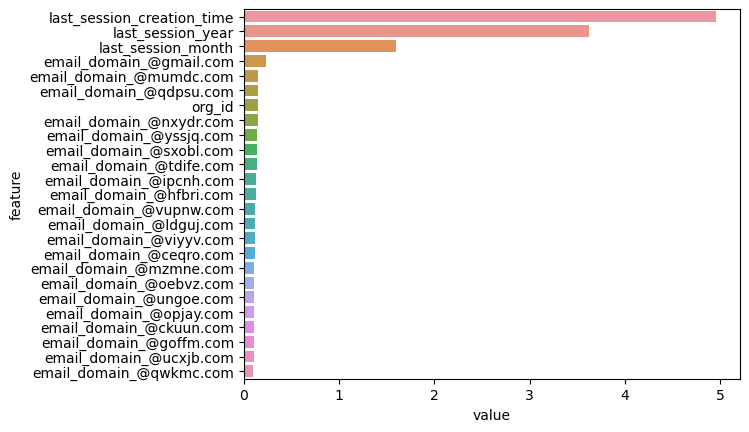

In [29]:
feature_coefs = pd.DataFrame({'feature':lr.feature_names_in_, 'value':np.ravel(lr.coef_)})
feature_coefs.sort_values('value', ascending=False, ignore_index=True, inplace=True)
sns.barplot(data=feature_coefs[:25], y='feature', x='value')
plt.show()

In [30]:
# get predictions
y_pred_lr = lr.predict(X_test_scaled)

In [31]:
print('accuracy:  ' + str(accuracy_score(y_test, y_pred_lr)) + ' ' + str(str(accuracy_score(y_test, y_pred_lr, normalize=False))) + '/' + str(str(len(y_test))))
print('precision: ' + str(precision_score(y_test, y_pred_lr)))
print('recall:    ' + str(recall_score(y_test, y_pred_lr)))

accuracy:  0.9639865996649917 1151/1194
precision: 0.92
recall:    0.8473684210526315


### Conclusion

To identity which factors predict future user adoption the best, I chose to look at the feature importances calculated from a random forest model, fitted with the user data. The model's feature importances are calculated from averaged gini gain at each node in the tree for the different features. The model weighted features created from the user account creation and last session the highest, as they are the strongest indicators of a user being adopted. Specifically, the top few features were:
1. last_session_creation_time
2. last_session_year
3. creation_time
4. last_session_month
5. creation_month

Interestingly, features such as which organization code a user belonged to or whether they opted into a drip campaign do not carry much importance when it comes to determining an adopted user.

To verify the feature importances from the model will be useful, I evaluated the model's predictions to find its accuracies. The random forest model was able to predict 72% of the users that should have been labeled adopted as adopted (the recall metric). However, no optimization of the model was investigated.

A logistic regression model was also tested to see if the results varied much from the random forest. Although the logistic regression model had better performance (84% recall) than the random forest model, the feature importances from the random forest model were easier to explain than the feature importances of the logistic regression model.

I recommend further investigating feature creation to aim for new features that rank as high as the time-valued features as the time that a user logs into the product does not provide much context into why they are returning to the product. The feature I recommend investigating first is:
1. Whether a user was recommended by another user or not (I deleted NaN rows in this example and therefore did not investigate this)